PRE-PROCESSING STEPS

In [32]:
import os
import textract
import PyPDF2
import docx
import pandas as pd
import pytesseract
from PIL import Image
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import inflect

# Download necessary nltk data (if needed)
# nltk.download('stopwords')
# nltk.download('wordnet')

# Set up inflect engine for number-to-word conversion
p = inflect.engine()

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Set Tesseract OCR Path (Windows Only)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

#----------------------------
# TEXT EXTRACTION FUNCTIONS
#----------------------------
def extract_text_from_docx(file_path):
    try:
        doc = docx.Document(file_path)
        return "\n".join([para.text for para in doc.paragraphs])
    except Exception as e:
        print(f"Error extracting text from {file_path} using python-docx: {e}")
        return None

def extract_text_from_pdf(file_path):
    try:
        with open(file_path, "rb") as file:
            reader = PyPDF2.PdfReader(file)
            text = "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])
            return text if text else None
    except Exception as e:
        print(f"Error extracting text from {file_path} using PyPDF2: {e}")
        return None

def extract_text_from_image(file_path):
    try:
        image = Image.open(file_path)
        text = pytesseract.image_to_string(image, config='--psm 6')
        return text.strip() if text else None
    except Exception as e:
        print(f"Error extracting text from {file_path} using OCR: {e}")
        return None

def extract_text(file_path):
    """Detect file type and extract text accordingly."""
    text = None
    if file_path.endswith(".docx"):
        text = extract_text_from_docx(file_path)
    elif file_path.endswith(".pdf"):
        text = extract_text_from_pdf(file_path)
    elif file_path.endswith((".jpg", ".jpeg", ".png", ".JPG")):
        text = extract_text_from_image(file_path)
    
    # Fallback to Textract if primary extraction fails
    if text is None:
        try:
            text = textract.process(file_path).decode("utf-8")
        except Exception as e:
            print(f"Error extracting text from {file_path} using textract: {e}")
            return None
    
    return text

#----------------------------
# TEXT PREPROCESSING
#----------------------------
def preprocess_text(text):
    """Lowercase, remove special characters, normalize numbers, lemmatize, and remove stopwords."""
    if not text:
        return ""

    text = text.lower()
    
    # Normalize numbers (convert digits to words)
    words = text.split()
    normalized_words = []
    for word in words:
        if word.isdigit():  # Check if it's a number
            try:
                word = p.number_to_words(int(word))  # Convert to words
            except:
                word = p.number_to_words(int(word))
                # pass  # If conversion fails, keep the original number
        normalized_words.append(word)
    
    text = " ".join(normalized_words)

    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    # Lemmatization and Stopword Removal
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    return text

#----------------------------
# JACCARD SIMILARITY
#----------------------------
# def calculate_jaccard_similarity(text1, text2):
#     set1, set2 = set(text1.split()), set(text2.split())
#     intersection = set1.intersection(set2)
#     union = set1.union(set2)
#     return len(intersection) / len(union) if union else 0, intersection

#----------------------------
# PROCESS FILES & GENERATE CSV
#----------------------------
def process_files(resume_folder, job_folder, output_csv):
    data = []
    resumes = []
    job_requirements = []
    
    # Extract and preprocess resumes
    for filename in os.listdir(resume_folder):
        file_path = os.path.join(resume_folder, filename)
        if file_path.endswith((".pdf", ".docx", ".jpg", ".jpeg", ".png", ".JPG")):
            print(f"Extracting text from resume: {filename}")
            text = extract_text(file_path)
            if text:
                resumes.append({"filename": filename, "text": preprocess_text(text)})

    # Extract and preprocess job descriptions
    for filename in os.listdir(job_folder):
        file_path = os.path.join(job_folder, filename)
        if file_path.endswith((".pdf", ".docx", ".jpg", ".jpeg", ".png", ".JPG")):
            print(f"Extracting text from job requirement: {filename}")
            text = extract_text(file_path)
            if text:
                job_requirements.append({"filename": filename, "text": preprocess_text(text)})

    # Compute Jaccard similarity
    for resume in resumes:
        for job in job_requirements:
            jaccard_score_value, common_words = calculate_jaccard_similarity(resume["text"], job["text"])
            data.append({
                "Resume Text": resume["text"],
                "Job Text": job["text"],
                "Job Role":job["filename"],
                # "Jaccard Score": jaccard_score_value,
                # "Common Words": " ".join(common_words)  # Convert set to string
            })

    # Save to CSV
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"Extraction complete. Data saved to {output_csv}")

# Example usage
resume_folder = "C:/Users/Acer/Desktop/Talaba,Ephraim/ARSwithPredictiveAnalytics/Data-Training/dataset-inputs/resumes"  # Change this to your resume folder path
job_folder = "C:/Users/Acer/Desktop/Talaba,Ephraim/ARSwithPredictiveAnalytics/Data-Training/dataset-inputs/job requirements"  # Change this to your job requirements folder path
output_csv = "C:/Users/Acer/Desktop/Talaba,Ephraim/ARSwithPredictiveAnalytics/Data-Training/dataset-outputs/dataset-for-xgboost.csv"
process_files(resume_folder, job_folder, output_csv)


Extracting text from resume: Accounting Profesional.pdf
Extracting text from resume: Computer-Engineer.pdf
Extracting text from resume: Cybersecurity.pdf
Extracting text from resume: Data-Encoder.pdf
Extracting text from resume: Data-Scientist.pdf
Extracting text from resume: Freelance.pdf
Extracting text from resume: Graphic Artist.pdf
Extracting text from resume: IMG_6142.JPG
Extracting text from resume: IMG_6143.JPG
Extracting text from resume: IMG_6144.JPG
Extracting text from resume: IMG_6145.JPG
Extracting text from resume: IMG_6146.JPG
Extracting text from resume: IMG_6147.JPG
Extracting text from resume: IMG_6148.JPG
Extracting text from resume: IMG_6149.JPG
Extracting text from resume: IMG_6150.JPG
Extracting text from resume: IMG_6151.JPG
Extracting text from resume: IMG_6152.JPG
Extracting text from resume: IMG_6153.JPG
Extracting text from resume: IMG_6154.JPG
Extracting text from resume: IMG_6155.JPG
Extracting text from resume: IMG_6156.JPG
Extracting text from resume: IM

To predict a suitable role or position:

In [13]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
file_path = "C:/Users/Acer/Desktop/Talaba,Ephraim/ARSwithPredictiveAnalytics/Data-Training/dataset-outputs/dataset-for-xgboost.csv"  
df = pd.read_csv(file_path)

# Convert text into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
X_resumes = vectorizer.fit_transform(df["Resume Text"])
X_jobs = vectorizer.transform(df["Job Requirement"])

# Combine both features
X = np.hstack((X_resumes.toarray(), X_jobs.toarray()))

# Encode job roles
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Job Roles"])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Function to predict job role for a new resume
def predict_job_role(resume_text, job_requirement_text):
    processed_resume = preprocess_text(resume_text)
    processed_job = preprocess_text(job_requirement_text)
    
    resume_tfidf = vectorizer.transform([processed_resume])
    job_tfidf = vectorizer.transform([processed_job])
    
    combined_features = np.hstack((resume_tfidf.toarray(), job_tfidf.toarray()))
    
    predicted_label = model.predict(combined_features)[0]
    return label_encoder.inverse_transform([predicted_label])[0]

# Example Prediction
new_resume = "Experienced web developer with knowledge in Python, JavaScript, and databases."
new_job_requirement = "Looking for a full-stack developer with expertise in Python and JS."

predicted_role = predict_job_role(new_resume, new_job_requirement)
print("Predicted Job Role:", predicted_role)

c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.00
Classification Report:
                                          precision    recall  f1-score   support

                        AREA SUPERVISOR       1.00      1.00      1.00        75
               AU Legal Admin Assistant       1.00      1.00      1.00        66
                    Accounts Specialist       1.00      1.00      1.00        76
                        Admin Assistant       1.00      1.00      1.00        80
                            Admin clerk       1.00      1.00      1.00        74
              Amazon Listing Specialist       1.00      1.00      1.00        76
               Automation Test Engineer       1.00      1.00      1.00        82
                      Bilingual Speaker       1.00      1.00      1.00        82
                             Bookkeeper       1.00      1.00      1.00        86
           Business Development Analyst       1.00      1.00      1.00        85
                                CASHIER       1.00      1.00      1.0

In [29]:

# Function to predict job role for a new resume
def predict_job_role(resume_text, job_requirement_text):
    processed_resume = preprocess_text(resume_text)
    processed_job = preprocess_text(job_requirement_text)
    
    resume_tfidf = vectorizer.transform([processed_resume])
    job_tfidf = vectorizer.transform([processed_job])
    
    combined_features = np.hstack((resume_tfidf.toarray(), job_tfidf.toarray()))
    
    predicted_label = model.predict(combined_features)[0]
    return label_encoder.inverse_transform([predicted_label])[0]

# Example Prediction
new_resume = ""
new_job_requirement = "service crew"

predicted_role = predict_job_role(new_resume, new_job_requirement)
print("Predicted Job Role:", predicted_role)

Predicted Job Role: OFFICE STAFF


--------------------------------------------------------------

---------------------------------------------------------------------

To get an output like this:


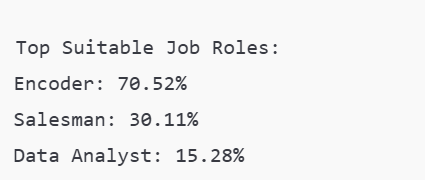


Here is the code below!!!

In [33]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
data = pd.read_csv("C:/Users/Acer/Desktop/Talaba,Ephraim/ARSwithPredictiveAnalytics/Data-Training/dataset-outputs/dataset-for-xgboost.csv")  # Ensure your dataset file is named correctly

# Extract features and labels
X_text = data["Resume Text"] + " " + data["Job Text"]  # Combine Resume & Job Descriptions
y = data["Job Role"]

# Convert text into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)  # You can tune this
X_tfidf = vectorizer.fit_transform(X_text)

# Encode job roles as numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", use_label_encoder=False)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Save trained model and encoders
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ Model training complete! Model saved as xgboost_model.pkl")


c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.9992308537523349
                                         precision    recall  f1-score   support

               AU Legal Admin Assistant       1.00      1.00      1.00        96
                    Accounts Specialist       1.00      1.00      1.00       108
                        Admin Assistant       0.99      1.00      0.99        99
                            Admin Clerk       0.98      1.00      0.99        94
              Amazon Listing Specialist       1.00      1.00      1.00        99
                        Area Supervisor       1.00      1.00      1.00       178
               Automation Test Engineer       0.99      0.99      0.99       108
                      Bilingual Speaker       1.00      1.00      1.00        91
                             Bookkeeper       1.00      1.00      1.00        86
           Business Development Analyst       1.00      1.00      1.00        98
                      Call Center Agent       1.00      1.00      1.00   